# PCA on GrassmannManifold

In this Notebook we will see how to do Principal Component Analysis (PCA). principal components analysis (PCA) by viewing it as an optimization problem on the Grassmann manifold, i.e.,

$$\min_{\textbf{U} \in \mathcal{G}(m, r)} \frac{1}{n} \sum_{i=1}^{n} \Vert\textbf{z}_{i} - \textbf{U}\textbf{U}^T \text{z}_i\Vert_{2}^2,$$

where $\textbf{z}_i \in \mathbb{R}^n$ denote the data points. Where $ \mathcal{G}(m, r)$ denotes Grassmann Manifold

In [1]:
# machine spec 
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())



print('--CPU--')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')
print('--RAM--')
run('cat /proc/meminfo | egrep "^MemTotal"')
print("--GPU--")
!nvidia-smi

--CPU--
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.166
cpu cores	: 1
--RAM--
MemTotal:       16390868 kB
--GPU--
Tue Oct 11 15:49:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+-----

In [2]:
!pip install git+https://github.com/SaitejaUtpala/rieoptax.git

  Cloning https://github.com/SaitejaUtpala/rieoptax.git to /tmp/pip-req-build-6vewbu89
  Running command git clone --filter=blob:none --quiet https://github.com/SaitejaUtpala/rieoptax.git /tmp/pip-req-build-6vewbu89
  Resolved https://github.com/SaitejaUtpala/rieoptax.git to commit 287d982809d55b62e76bc19580f44b1661d91d46
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for rieoptax: filename=rieoptax-0.0.1-py3-none-any.whl size=13434 sha256=f18b85f87221b76d2996961e09dd434930d879af08312a3bb6136f8ede24250d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6oie37ez/wheels/db/bf/d0/1494573aece1897996bcf6f222dc98d68acd429080c6f16690
  Created wheel for autodp: filename=autodp-0.2-py3-none-any.whl size=42458 sha256=bc37d15d847b926f6a58997a06d9a5da515876d32f71bd57c5869897ec7dc920
  Stored in directory: /root/.cache/pip/wheels/6a/95/85/6a1fc999268b5ed5aaeb387ff91f0063698b8a4db55e5c38c5
Successfully built rieoptax autodp


In [3]:
seed = 0

In [4]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

from timeit import default_timer as timer

from jax.config import config
from jax import jit, vmap
from jax import numpy as jnp
from jax.numpy.linalg import norm
from jax import random

config.update("jax_enable_x64", True) # run jax at float64 bit precision

from rieoptax.core import ManifoldArray, rgrad
from rieoptax.geometry.grassmann import GrassmannCanonical
from rieoptax.optimizers.first_order import  rsgd
from rieoptax.optimizers.update import apply_updates

### Preparing the data 

Fot this Notebook we will be using Tiny Imagenet. Tiny Imagenet consists of 100,000 images  of shape (3,64,64). We take $5\,000$ images and vectorize each image to produce a sample matrix of size $(n, d) = (5\,000, 12\,288)$. We compute the top $r = 5$ principal components, which leads to an optimization problem on $\mathcal{G}(12\,288, 5)$ whose dimension is $61415$ (which is high!). We will see Rieoptax is very efficient. 

In [5]:
!wget  http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
!ls

--2022-10-11 15:50:13--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  16.8MB/s    in 17s     

2022-10-11 15:50:31 (14.1 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

__notebook_source__.ipynb  tiny-imagenet-200  tiny-imagenet-200.zip


In [7]:
import cv2
import glob
from tqdm import tqdm 

TRAINPATH = "tiny-imagenet-200/train/*/images/*.JPEG"
images = [cv2.imread(file) for file in tqdm(sorted(glob.glob(TRAINPATH))[:5000])]
jnp_data = jnp.asarray(images[:5000], dtype=jnp.float64).reshape(5000,-1)/255
print("Data shape", jnp_data.shape)

100%|██████████| 5000/5000 [00:00<00:00, 5638.14it/s]


Data shape (5000, 12288)


In [9]:
from sklearn.decomposition import PCA


number_of_comonents = 5
pca = PCA(number_of_comonents)
pca.fit(jnp_data)
final = pca.components_


mean = jnp.asarray(pca.mean_).reshape(1,-1)
centered_jnp_data = jnp_data - mean
print("a", centered_jnp_data.shape)
minimum_loss = (jnp.linalg.norm(centered_jnp_data.T - final.T @ (final @ centered_jnp_data.T))**2)/centered_jnp_data.shape[0]
print("min_loss", minimum_loss)

a (5000, 12288)
min_loss 406.17845869728365


In [11]:
# generate column orthonormal matrix used for intialization 

def qr_method(rng_key, n, m):
    X = random.normal(rng_key, shape = (n,m))
    Q, _ = jnp.linalg.qr(X)
    return Q

r = number_of_comonents
n,m = centered_jnp_data.shape
key = random.PRNGKey(seed)
jnp_init = qr_method(key,m,r)
print(jnp_init.shape)

(12288, 5)


### Fit function 

Rieoptax fit function is similar to Optax with single important difference:  **rgrad** is used instead of **grad**

In [12]:
def fit(params, data, optimizer, epochs):
    @jit 
    def step(params, opt_state, data):

        def cost(params, data):
            def _cost(params, data):
                return norm(data-params.value@(params.value.T @ data))**2
            return vmap(_cost, in_axes=(None,0))(params, data).mean()

        rgrads = rgrad(cost)(params, data) #calculates Riemannian gradients
        updates, opt_state = optimizer.update(rgrads, opt_state, params)
        params = apply_updates(params, updates) #Update using Riemannian Exp
        loss_value = cost(params, data)
        return params, opt_state, loss_value

    opt_state = optimizer.init(params)
    rieoptax_loss = []
    rieoptax_time = []
    start = timer()
    for i in range(epochs):
        params, opt_state, loss_value = step(params, opt_state, data)
        #print("a", loss_value)
        elapsed_time = timer() - start
        rieoptax_loss.append(loss_value)
        rieoptax_time.append(elapsed_time)


    return rieoptax_loss, rieoptax_time

In [17]:
U_init = ManifoldArray(value=jnp_init, manifold=GrassmannCanonical(m, r))    
epochs = 200
lr = 2e-3
optimizer = rsgd(lr)
rieoptax_loss, rieoptax_time = fit(U_init, centered_jnp_data, optimizer, epochs)

2022-10-11 15:52:04.993333: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


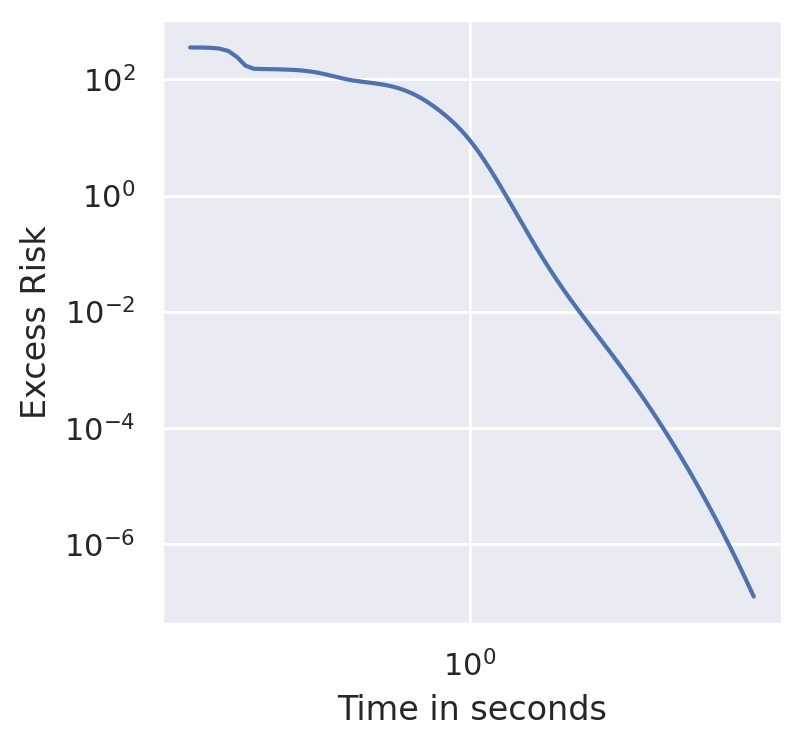

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set_style("darkgrid")


fig, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
axes.plot(jnp.asarray(rieoptax_time),  jnp.asarray(rieoptax_loss) - jnp.asarray(minimum_loss))
axes.set_yscale("log")
axes.set_xscale("log")
axes.set_ylabel("Excess Risk")
axes.set_xlabel("Time in seconds")
plt.show()

### Conclusion : 

It just 3 seconds took to obtain Excess risk $10^{-7}$ for optimization problem on 61415 dimensional Grassmann!